# XGBoost

In [1]:
import json
import random
import time

import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import trange
from xgboost import XGBClassifier

from tools import (Modelisation, SearchCV, best_score_CV, datasets,
                   graph_2scores_CV, graph_2scores_CV_comp, graph_3scores_CV,
                   graph_param_CV, restauration_CV, PDF)

pdf = PDF('output/model_xgboost/')

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant : default
Columns_cat : default
drop : if_binary

Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 56



Index(['display_env_app_android', 'display_env_app_ios', 'display_env_other',
       'display_env_web', 'target_env_2', 'campaignscenario_0',
       'campaignscenario_5', 'campaignscenario_6', 'campaignscenario_11',
       'campaignscenario_12', 'campaignscenario_13', 'campaignscenario_17',
       'campaignvertical_14.0', 'campaignvertical_20.0',
       'campaignvertical_23.0', 'campaignvertical_129.0',
       'campaignvertical_200002.0', 'is_interstitial_True',
       'device_type_Android', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Friday',
       'weekday_Monday', 'weekday_Satur


Nombre de variables pour X : 69


In [4]:
len(y[y == 0]) / (len(y[y == 1]))

16.529395045803362

## 1. Modèle brut
### 1.1. Variables quantitatives

Export PDF : output/model_xgboost/00.pdf



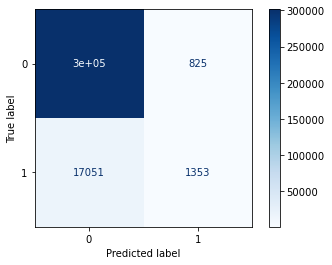

f1 : 0.1315
f3 : 0.0806
f5 : 0.0761
recall : 0.0735
negative predictive value : 0.9465
precision : 0.6212
roc_auc : 0.8277
training time : 21.79s
prediction time : 0.124s


In [5]:
m = Modelisation(X_quant, y, XGBClassifier(n_jobs=-1))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

Export PDF : output/model_xgboost/01.pdf



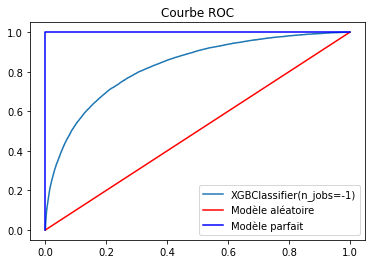

In [6]:
m.show_ROC(pdf=pdf)

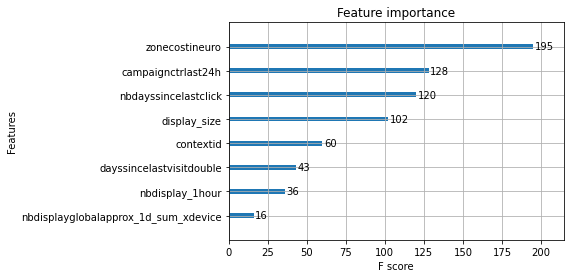

In [7]:
m.plot_importance()

Affichage d'un arbre (par défaut le premier parmi les autres) :

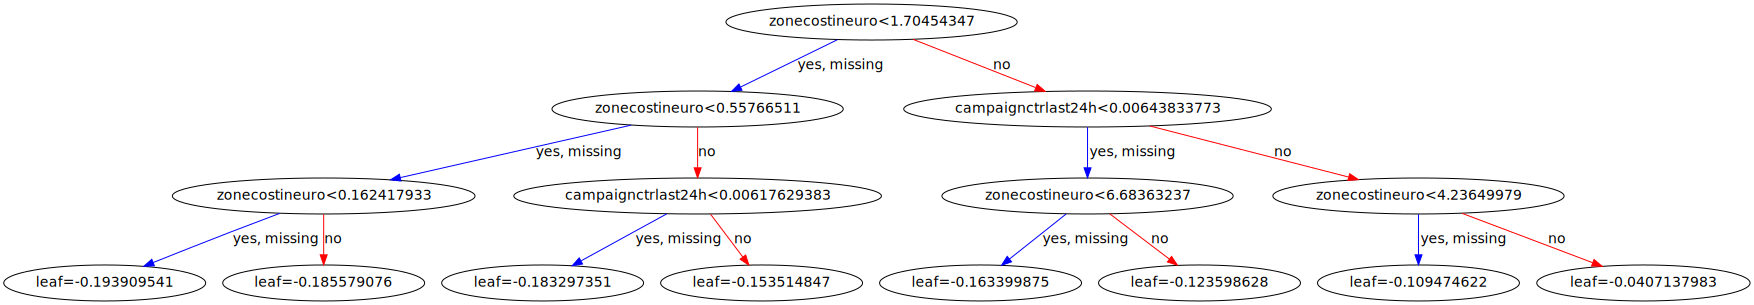

In [8]:
m.show_graph()

### 1.2. Variables catégorielles

Export PDF : output/model_xgboost/02.pdf



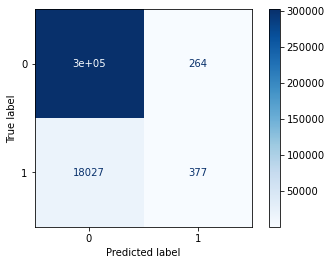

f1 : 0.0396
f3 : 0.0227
f5 : 0.0213
recall : 0.0205
negative predictive value : 0.9437
precision : 0.5881
roc_auc : 0.6923
training time : 21.258s
prediction time : 0.209s


In [9]:
m = Modelisation(X_cat, y, XGBClassifier(n_jobs=-1))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

Export PDF : output/model_xgboost/03.pdf



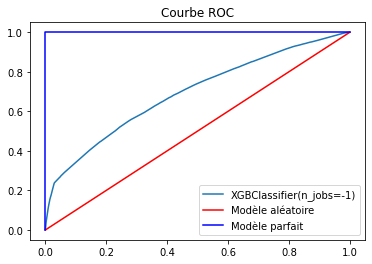

In [10]:
m.show_ROC(pdf=pdf)

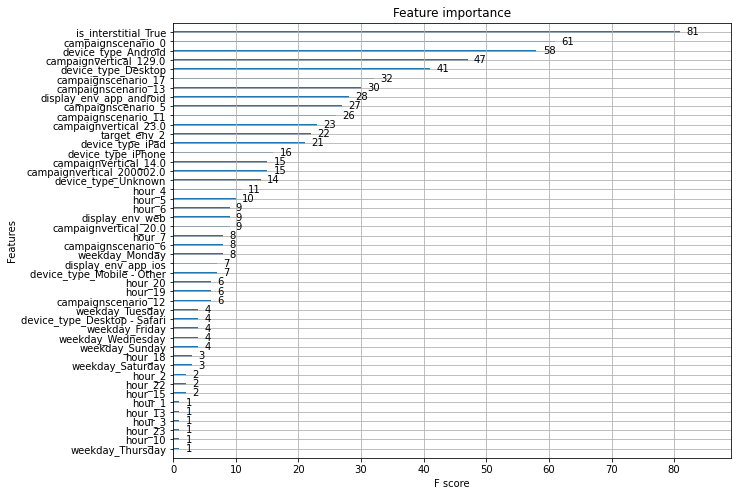

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
m.plot_importance(ax=ax)

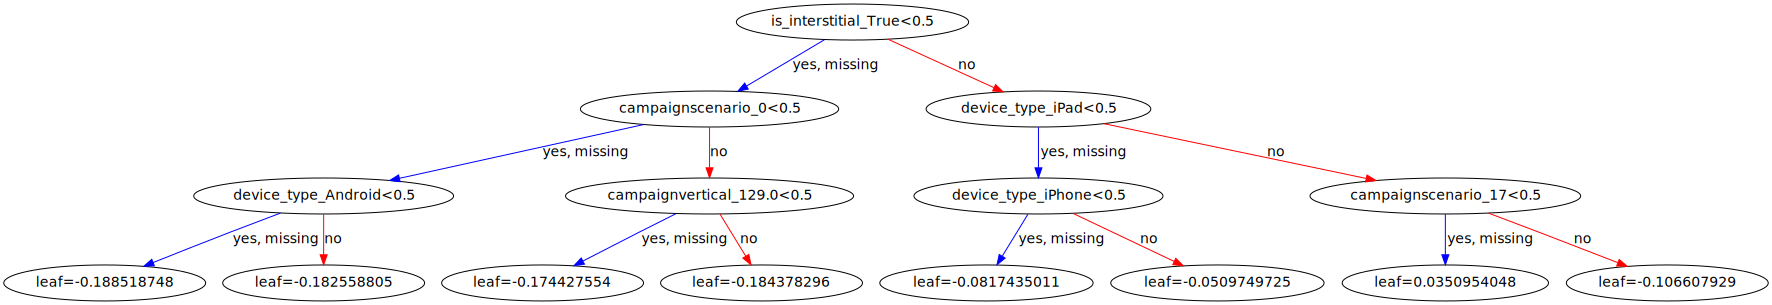

In [12]:
m.show_graph()

### 1.3. Variables quantitatives + catégorielles

Export PDF : output/model_xgboost/04.pdf



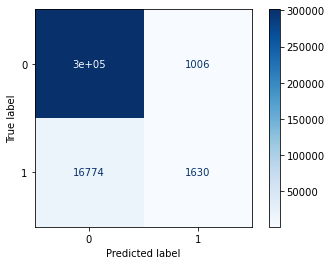

f1 : 0.1549
f3 : 0.0969
f5 : 0.0916
recall : 0.0886
negative predictive value : 0.9473
precision : 0.6184
roc_auc : 0.8351
training time : 28.475s
prediction time : 0.612s


In [13]:
m = Modelisation(X, y, XGBClassifier(n_jobs=-1))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

Export PDF : output/model_xgboost/05.pdf



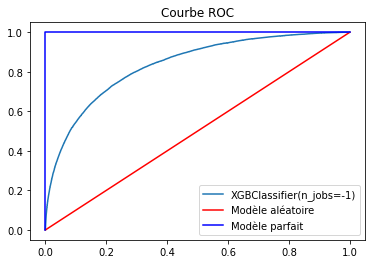

In [14]:
m.show_ROC(pdf=pdf)

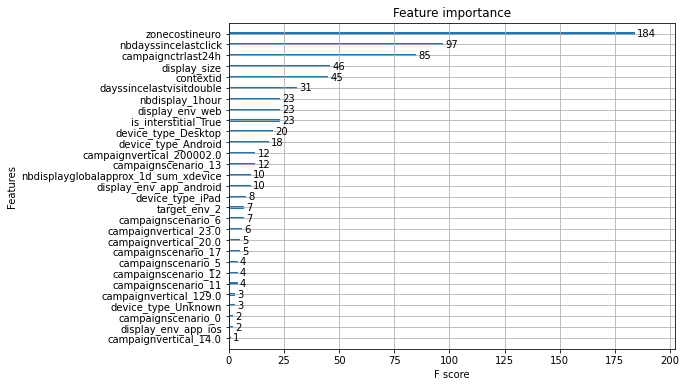

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
m.plot_importance(ax=ax)

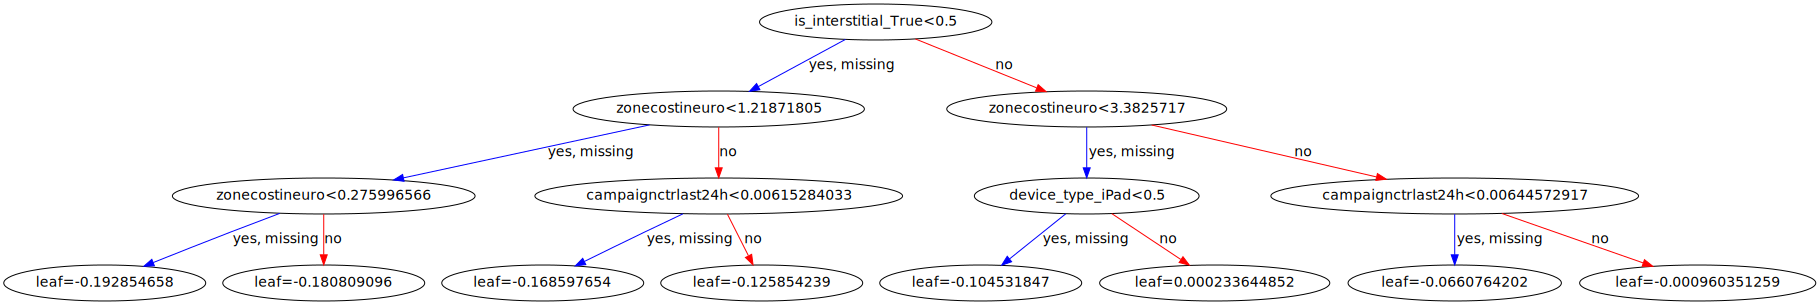

In [16]:
m.show_graph()

## 2. Tuning des hyperparamètres avec GridSearchCV

On calcule le GridSearchCV sur un dataset plus petit pour avoir un temps de calcul raisonnable.

### 2.1. Calcul et sauvegarde

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [17]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', n_jobs=1)

cv_params = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [2, 4, 6, 8, 10],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "scale_pos_weight": [1, 16.5]   # A typical value to consider: sum(negative instances) / sum(positive instances)
}

print(len(ParameterGrid(cv_params)))

54000


In [18]:
# SearchCV(model, cv_params, data_frac=0.02, random=True, n_iter=10000, random_state=1234, n_jobs=28)

### 2.2. Restauration des résultats

In [19]:
dico, results = restauration_CV('XGBoost_CV_Randomized10000_54000_0.02')

model : XGBClassifier()
model_name : XGBoost
type : RandomizedSearchCV
len_grid : 54000
n_iter : 10000
columns_quant : default
columns_cat : default
drop : if_binary
data_frac : 0.02
n_jobs : 28
temps : 9h, 49min, 35.958s
params : {'n_estimators': [50, 100, 150, 200, 300], 'max_depth': [2, 4, 6, 8, 10], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'gamma': [0.5, 1, 1.5, 2, 5], 'min_child_weight': [1, 3, 5, 10], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'scale_pos_weight': [1, 16.5]}
scoring : {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'f3': make_scorer(fbeta_score, beta=3), 'f5': make_scorer(fbeta_score, beta=5)}


In [20]:
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
0,4.827892,0.485978,0.056521,0.01461,1.0,1.0,150,1,2,0.1,...,2118,0.173507,0.010928,7455,0.111013,0.00851,7476,0.105186,0.008197,7476
1,6.217045,0.546666,0.06384,0.014702,0.6,16.5,150,3,2,0.01,...,8937,0.237898,0.00336,4431,0.505153,0.006016,1722,0.610761,0.008963,1035
2,5.76341,0.448612,0.082531,0.008073,1.0,1.0,50,5,8,0.1,...,1347,0.181085,0.017622,7345,0.116266,0.013744,7365,0.110204,0.013253,7369
3,5.272107,0.394883,0.059865,0.010045,1.0,1.0,200,5,2,0.1,...,1526,0.188802,0.018389,7223,0.122042,0.014409,7251,0.115751,0.013895,7252
4,27.123333,3.550873,0.141858,0.029233,0.8,1.0,300,1,4,0.01,...,487,0.136414,0.011146,8204,0.083752,0.007923,8248,0.079058,0.007574,8248
5,21.790071,3.194074,0.149382,0.022937,0.6,16.5,100,5,10,0.01,...,5658,0.307231,0.008899,222,0.443871,0.014732,3597,0.476508,0.016749,3646
6,16.884236,2.651525,0.102352,0.013627,0.6,1.0,150,10,6,0.3,...,4234,0.205529,0.023743,6052,0.143836,0.018945,5569,0.137497,0.018356,5540
7,36.681679,3.697563,0.312074,0.035006,1.0,16.5,200,3,10,0.01,...,5907,0.293811,0.008446,822,0.433293,0.014779,3756,0.467552,0.018105,3713
8,24.234646,3.449696,0.153731,0.003391,0.8,16.5,300,10,4,0.001,...,8665,0.246772,0.00259,4170,0.513709,0.005307,1053,0.616303,0.007861,695
9,5.92874,0.902768,0.049025,0.005734,0.6,16.5,100,1,2,0.01,...,9151,0.229306,0.004694,4667,0.496993,0.010158,1997,0.605877,0.014249,1312


**Graphiques XY avec 2 scores**

Export PDF : output/model_xgboost/06.pdf



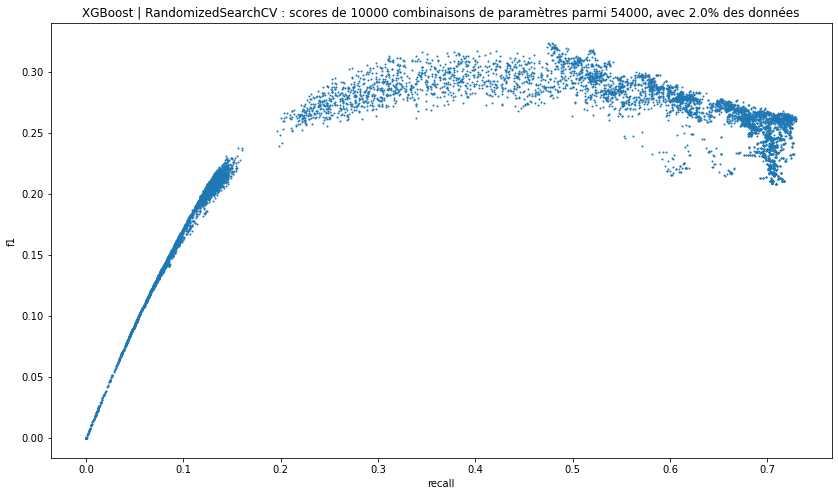

In [21]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=1, pdf=pdf)

Export PDF : output/model_xgboost/07.pdf



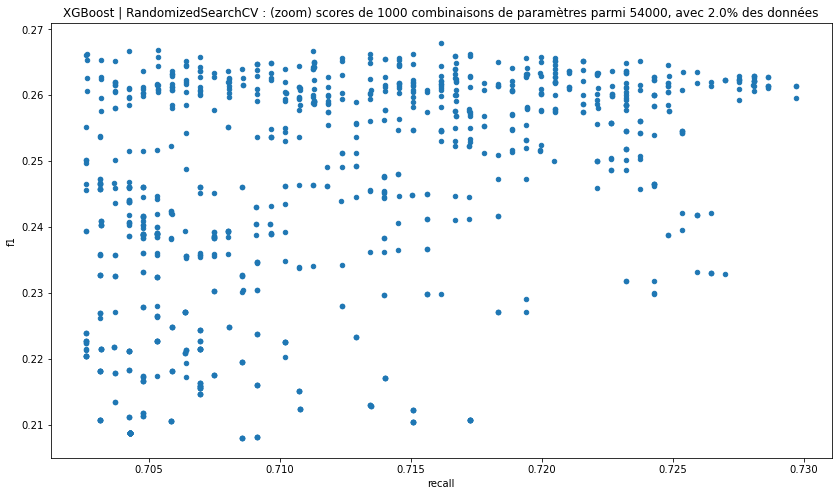

In [22]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20, zoom=0.1, pdf=pdf)

Export PDF : output/model_xgboost/08.pdf



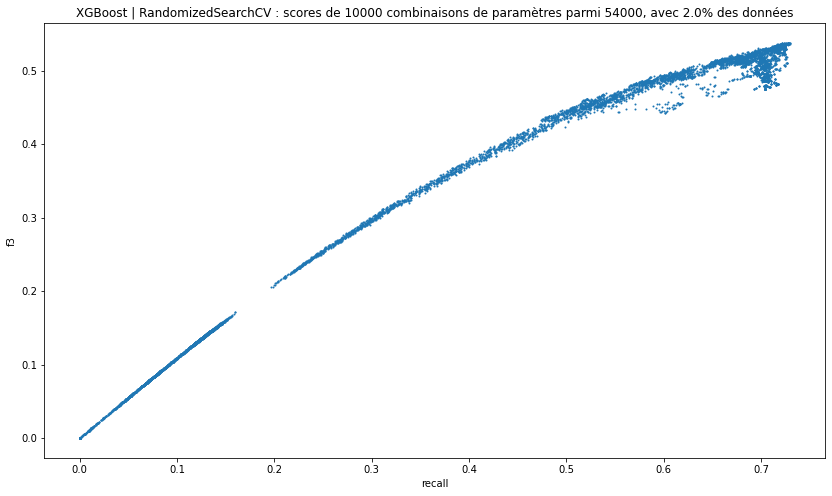

In [23]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=1, pdf=pdf)

Export PDF : output/model_xgboost/09.pdf



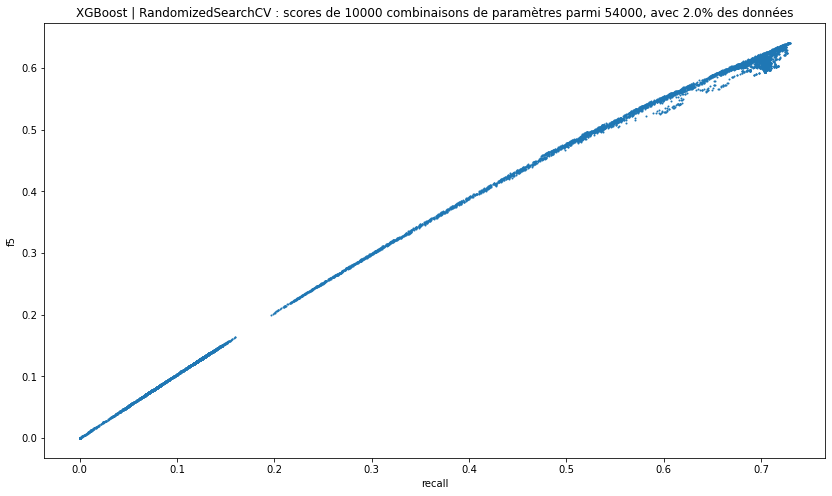

In [24]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=1, pdf=pdf)

Export PDF : output/model_xgboost/10.pdf



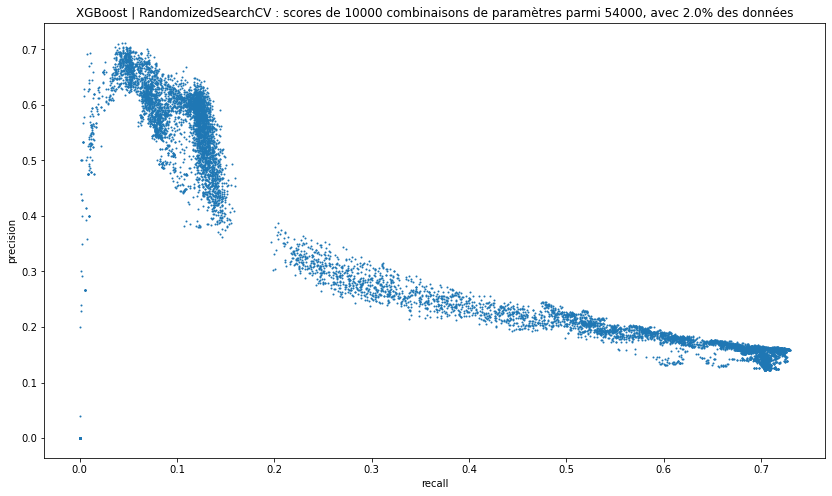

In [25]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=1, pdf=pdf)

**Graphique 3D avec 3 scores**

Export PDF : output/model_xgboost/11.pdf



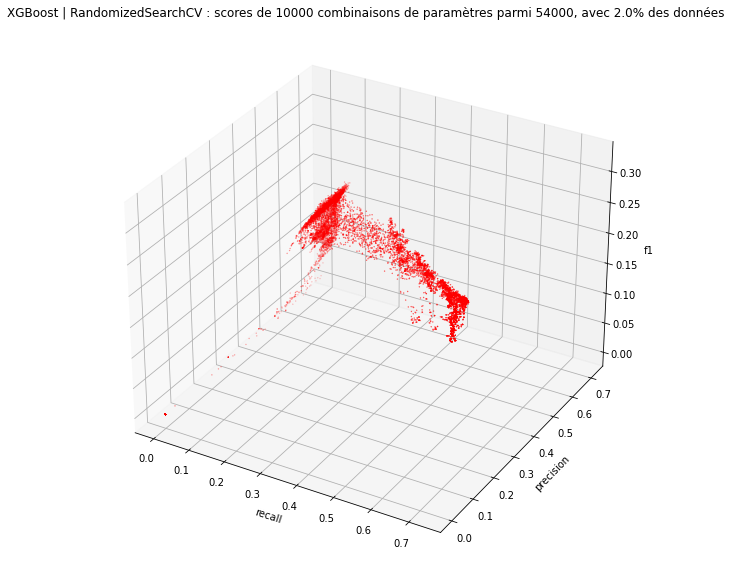

In [26]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=0.1, pdf=pdf)

Export PDF : output/model_xgboost/12.pdf



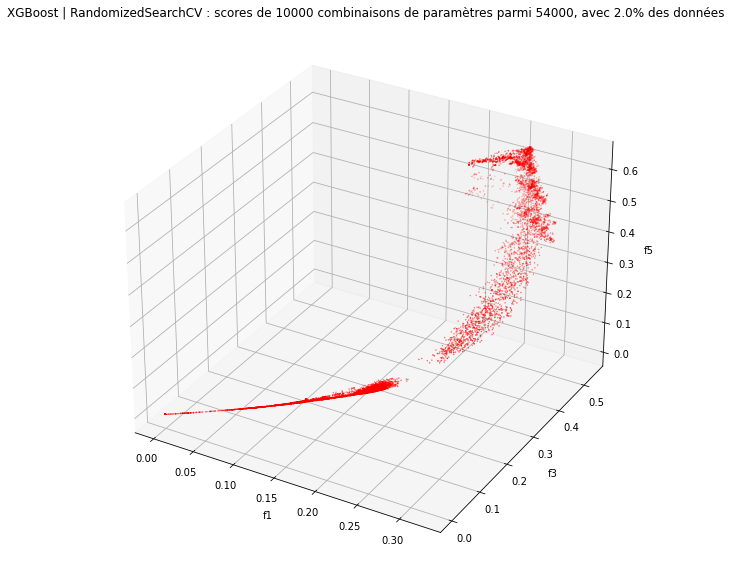

In [27]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=0.1, pdf=pdf)

**Graphiques de l'effet des paramètres**

Export PDF : output/model_xgboost/13.pdf



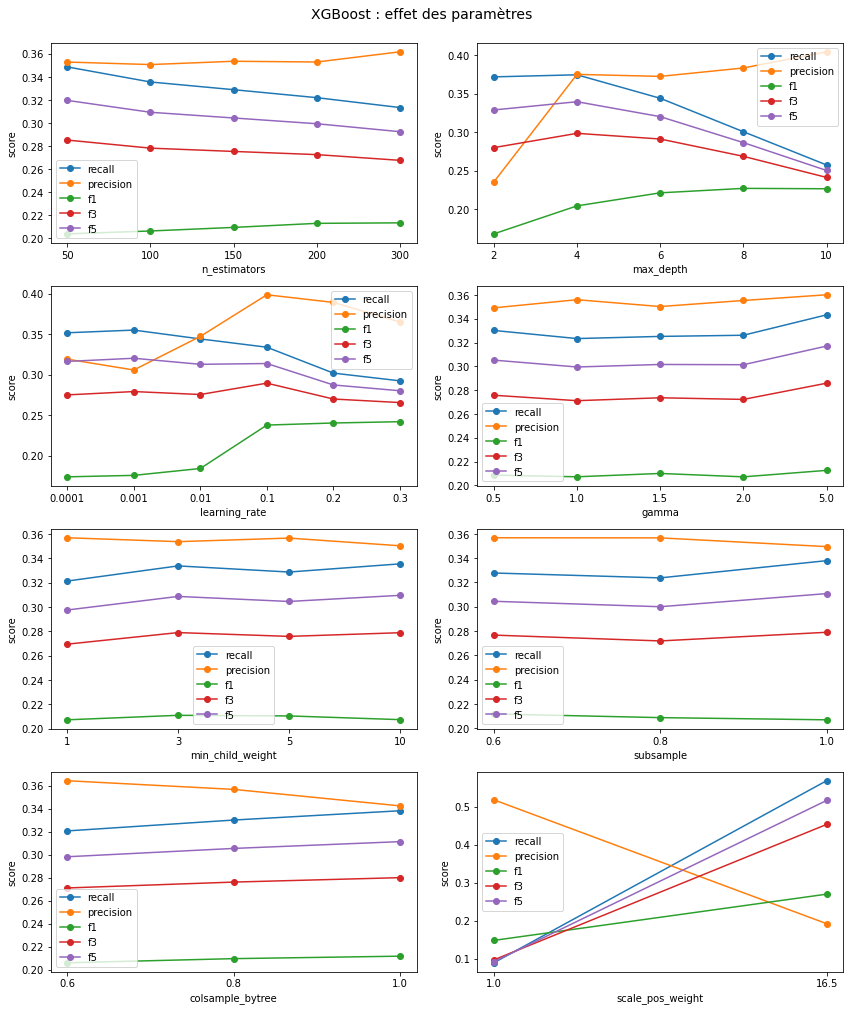

In [28]:
graph_param_CV(dico, results, ncols=2, height=3.5, width=6, pdf=pdf)

**Paramètres donnant le meilleur score**

In [29]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
1786,2.177735,0.316086,0.043524,0.006392,1.0,16.5,50,5,2,0.2,...,7965,0.262824,0.006993,3228,0.537922,0.012306,1,0.641186,0.014037,3
9619,1.948347,0.311994,0.039173,0.007207,1.0,16.5,50,5,2,0.2,...,7965,0.262824,0.006993,3228,0.537922,0.012306,1,0.641186,0.014037,3
4590,2.918276,0.381343,0.046433,0.005108,1.0,16.5,50,3,2,0.2,...,7953,0.262904,0.009571,3213,0.537715,0.014012,3,0.640807,0.014608,5
2622,2.734598,0.278516,0.042965,0.004356,1.0,16.5,50,3,2,0.2,...,7953,0.262904,0.009571,3213,0.537715,0.014012,3,0.640807,0.014608,5
6419,2.543272,0.390858,0.040283,0.008674,1.0,16.5,50,5,2,0.2,...,7955,0.262903,0.009563,3215,0.537714,0.013999,5,0.640807,0.014599,7
3050,5.892171,0.894119,0.063747,0.008351,1.0,16.5,150,10,2,0.1,...,7805,0.264559,0.009273,3023,0.537688,0.015505,6,0.639244,0.017332,31
4779,4.800132,0.706802,0.046777,0.008196,1.0,16.5,100,3,2,0.2,...,7754,0.265165,0.009542,2967,0.53768,0.012864,7,0.638714,0.012758,37
5075,2.705224,0.426299,0.040825,0.007048,1.0,16.5,50,1,2,0.2,...,7976,0.262674,0.009712,3248,0.537522,0.014365,8,0.640701,0.015075,8
9179,8.32296,1.062013,0.063236,0.007978,0.6,16.5,150,1,2,0.1,...,7949,0.262926,0.006974,3211,0.537514,0.009425,9,0.640439,0.009266,12
5608,4.577389,0.915383,0.062209,0.011874,1.0,16.5,150,3,2,0.1,...,7893,0.263513,0.010941,3138,0.537296,0.018022,10,0.639549,0.019763,29


Meilleure combinaison de paramètres pour f3 :


{'subsample': 1.0,
 'scale_pos_weight': 16.5,
 'n_estimators': 50,
 'min_child_weight': 5,
 'max_depth': 2,
 'learning_rate': 0.2,
 'gamma': 0.5,
 'colsample_bytree': 0.8}

In [30]:
best_params['booster'] = 'gbtree'
best_params['objective'] = 'binary:logistic'
best_params['n_jobs'] = -1
best_params['n_estimators'] = 100
PARAMS = {}
PARAMS[dico['model_name']] = best_params

**Analyse sur la base complète**

Export PDF : output/model_xgboost/14.pdf



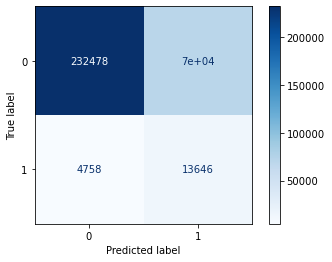

f1 : 0.2679
f3 : 0.5478
f5 : 0.6527
recall : 0.7415
negative predictive value : 0.9799
precision : 0.1635
roc_auc : 0.8355
training time : 18.251s
prediction time : 0.437s


In [31]:
m = Modelisation(X, y, XGBClassifier(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

SCORES = []
metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

Nous reproduisons le graphique f3 vs recall en prenant 10% des meilleures combinaisons (selon le f3), en fittant le modèle sur 10% des données.

In [32]:
"""%%time

df_small = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.1)
datasets_df_small = datasets(df_small, verbose=False)
X_small = datasets_df_small['X']
y_small = datasets_df_small['y']

f3_list = []
recall_list = []
params_list = []

results_sort = results.sort_values(by='mean_test_f3', ascending=False)

nb_tot = int(0.10 * len(results))
nb = 25

random.seed(1)
sample = random.sample(list(range(nb_tot)), nb)
for j in trange(nb):
    i = sample[j]
    params = results_sort.iloc[i].params
    m = Modelisation(X_small, y_small, XGBClassifier(**params))
    params_list.append(params)
    f3_list.append(m.metrics_score['f3'])
    recall_list.append(m.metrics_score['recall'])

plt.figure(figsize=(14, 8))
plt.scatter(recall_list, f3_list, marker='o')
plt.xlabel('recall')
plt.ylabel('f3')
plt.show()"""

"%%time\n\ndf_small = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.1)\ndatasets_df_small = datasets(df_small, verbose=False)\nX_small = datasets_df_small['X']\ny_small = datasets_df_small['y']\n\nf3_list = []\nrecall_list = []\nparams_list = []\n\nresults_sort = results.sort_values(by='mean_test_f3', ascending=False)\n\nnb_tot = int(0.10 * len(results))\nnb = 25\n\nrandom.seed(1)\nsample = random.sample(list(range(nb_tot)), nb)\nfor j in trange(nb):\n    i = sample[j]\n    params = results_sort.iloc[i].params\n    m = Modelisation(X_small, y_small, XGBClassifier(**params))\n    params_list.append(params)\n    f3_list.append(m.metrics_score['f3'])\n    recall_list.append(m.metrics_score['recall'])\n\nplt.figure(figsize=(14, 8))\nplt.scatter(recall_list, f3_list, marker='o')\nplt.xlabel('recall')\nplt.ylabel('f3')\nplt.show()"

**Test de paramètres**

In [33]:
params = {"colsample_bytree": 1.0, 
          "gamma": 1,
          "min_child_weight": 15,
          "scale_pos_weight": 16.5,
          "subsample": 0.8,
          "n_jobs": -1}

Export PDF : output/model_xgboost/15.pdf



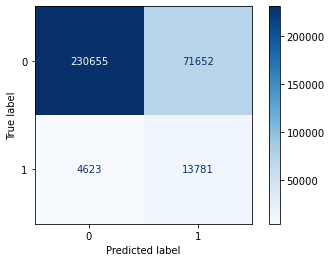

f1 : 0.2654
f3 : 0.5489
f5 : 0.6568
recall : 0.7488
negative predictive value : 0.9804
precision : 0.1613
roc_auc : 0.8363
training time : 29.923s
prediction time : 0.545s


In [34]:
m = Modelisation(X, y, XGBClassifier(**params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

## 3. XGBoost avec oversampling

### 3.1. GridSearchCV avec RandomOverSampler

In [35]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', XGBClassifier(booster='gbtree', objective='binary:logistic', n_jobs=1))
                         ])

cv_params = {
    "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    "model__n_estimators": [50, 100, 150, 200, 300],
    "model__max_depth": [2, 4, 6, 8, 10],
    "model__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    "model__gamma": [0.5, 1, 1.5, 2, 5],
    "model__min_child_weight": [1, 3, 5, 10],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__scale_pos_weight": [1, 16.5]   # A typical value to consider: sum(negative instances) / sum(positive instances)
}

print(len(ParameterGrid(cv_params)))

324000


In [36]:
# SearchCV(pipeline, cv_params, data_frac=0.02, random=True, n_iter=20000, random_state=1234, n_jobs=28)

In [37]:
dico, results = restauration_CV('RandomOver_XGBoost_CV_Randomized20000_324000_0.02')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', XGBClassifier())])
model_name : RandomOver_XGBoost
type : RandomizedSearchCV
len_grid : 324000
n_iter : 20000
columns_quant : default
columns_cat : default
drop : if_binary
data_frac : 0.02
n_jobs : 28
temps : 1day, 2h, 22min, 25.096s
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__n_estimators': [50, 100, 150, 200, 300], 'model__max_depth': [2, 4, 6, 8, 10], 'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'model__gamma': [0.5, 1, 1.5, 2, 5], 'model__min_child_weight': [1, 3, 5, 10], 'model__subsample': [0.6, 0.8, 1.0], 'model__colsample_bytree': [0.6, 0.8, 1.0], 'model__scale_pos_weight': [1, 16.5]}
scoring : {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'f3': make_scorer(fbeta_score, beta=3), 'f5': make_scorer(fbeta_score, beta=5)}


Export PDF : output/model_xgboost/16.pdf



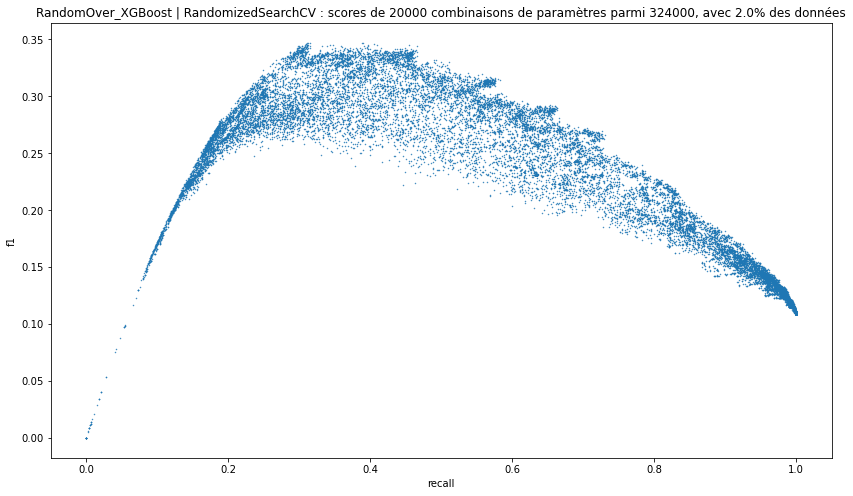

In [38]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=0.2, pdf=pdf)

Export PDF : output/model_xgboost/17.pdf



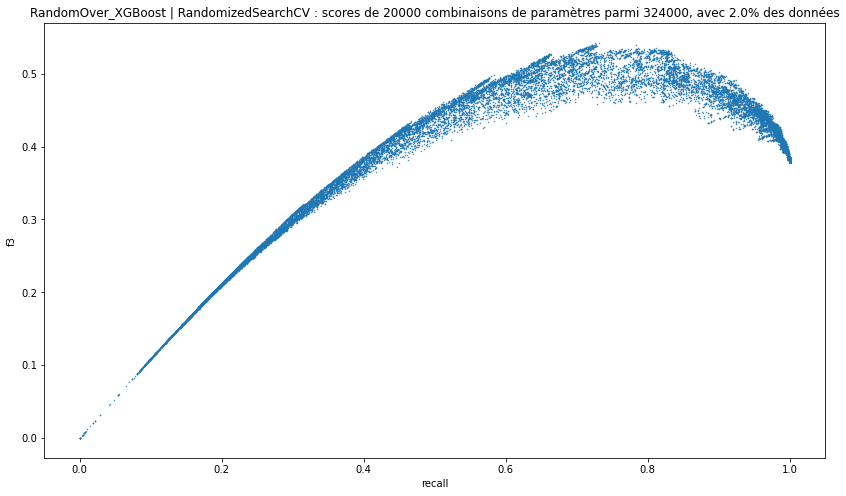

In [39]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=0.2, pdf=pdf)

Export PDF : output/model_xgboost/18.pdf



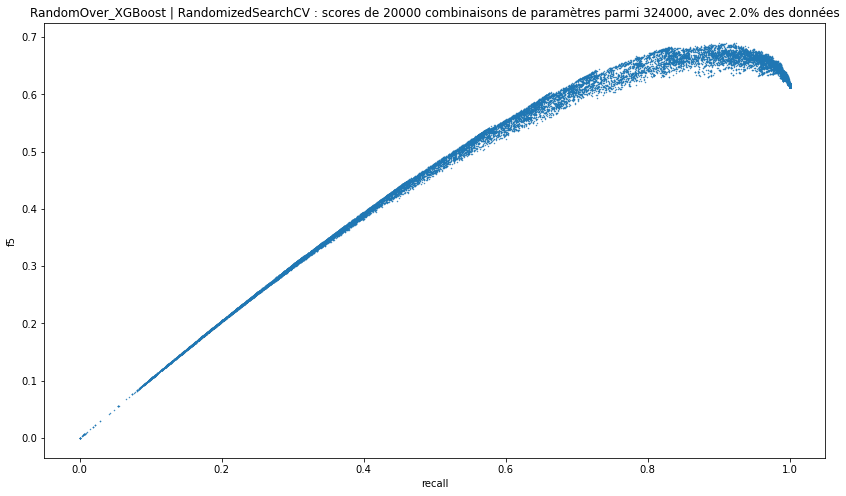

In [40]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=0.2, pdf=pdf)

Export PDF : output/model_xgboost/19.pdf



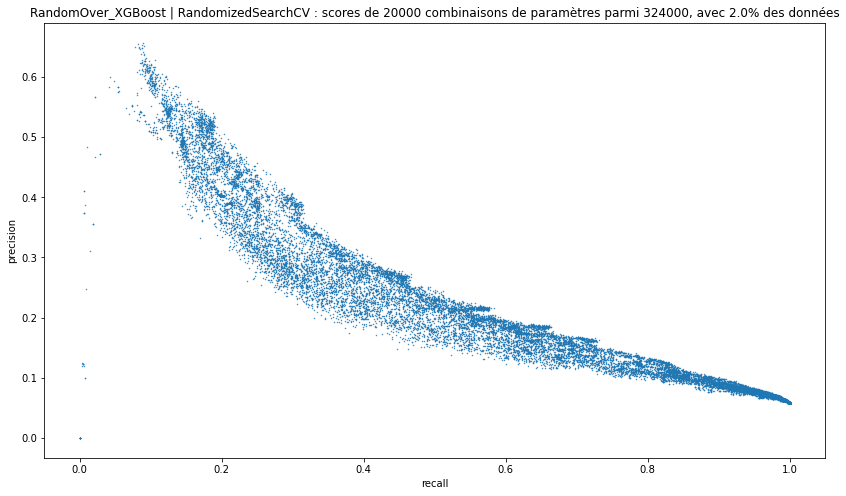

In [41]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=0.2, pdf=pdf)

Export PDF : output/model_xgboost/20.pdf



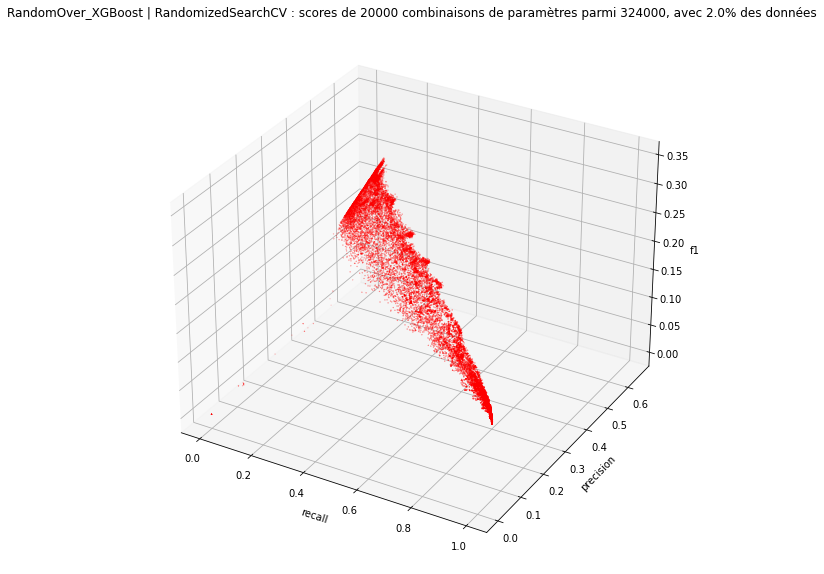

In [42]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=0.05, pdf=pdf)

Export PDF : output/model_xgboost/21.pdf



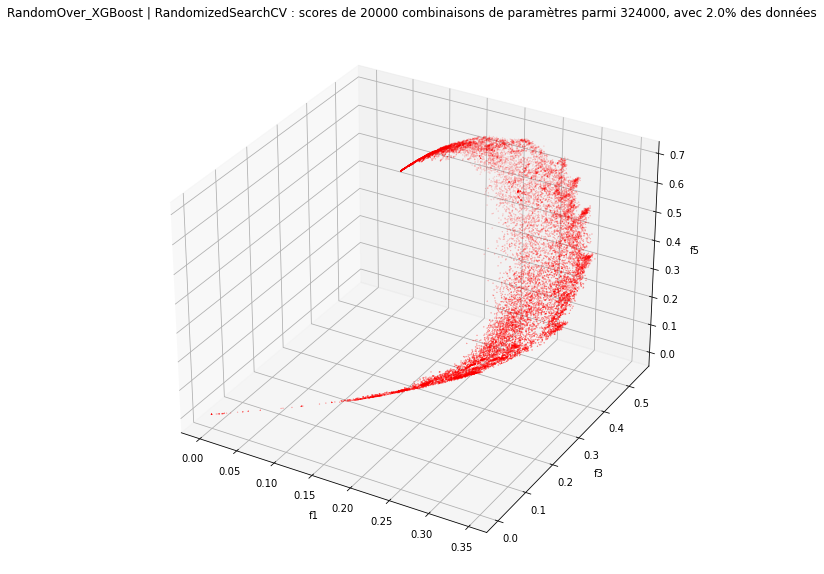

In [43]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=0.05, pdf=pdf)

Export PDF : output/model_xgboost/22.pdf



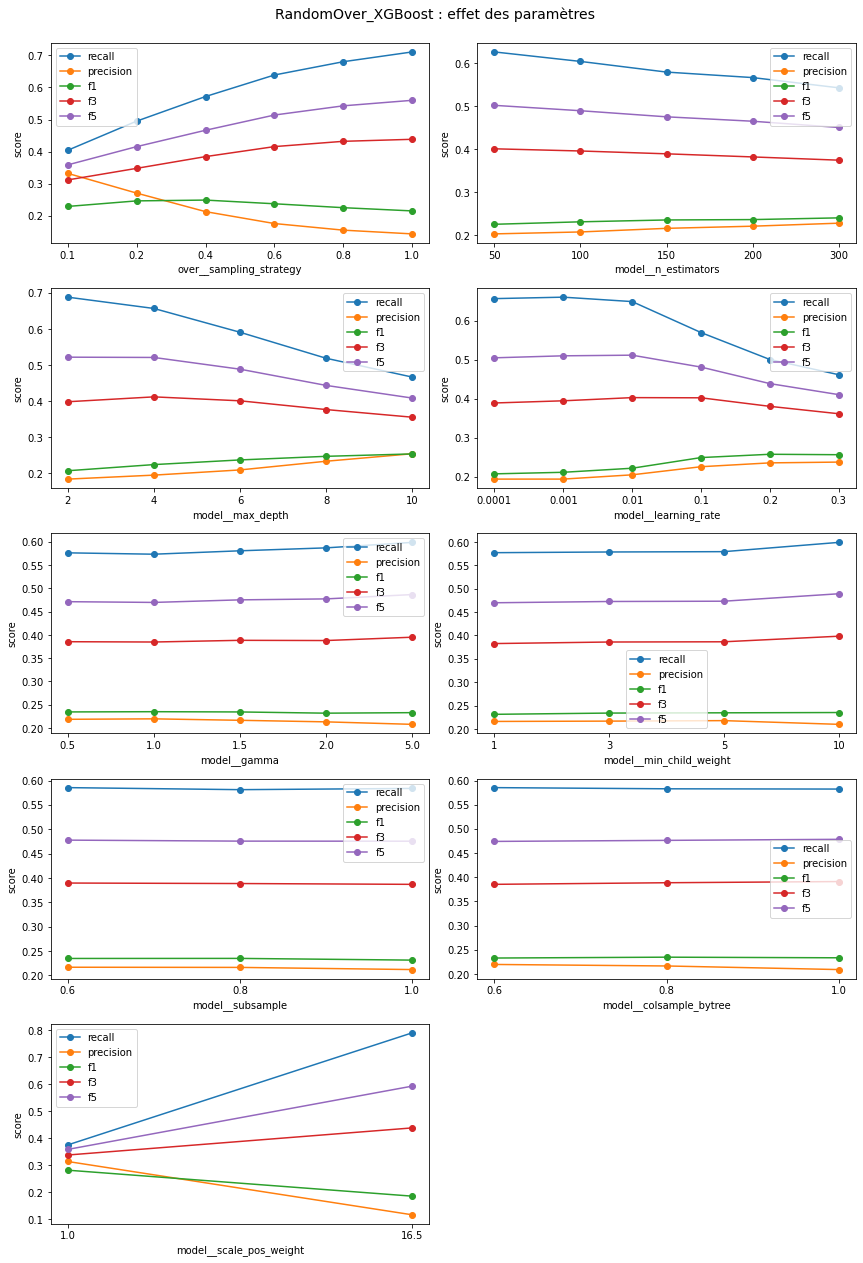

In [44]:
graph_param_CV(dico, results, ncols=2, height=3.5, width=6, pdf=pdf)

In [45]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_over__sampling_strategy,param_model__subsample,param_model__scale_pos_weight,param_model__n_estimators,param_model__min_child_weight,param_model__max_depth,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
4308,7.847867,1.04545,0.049696,0.005807,1.0,0.6,1.0,100,10,2,...,10863,0.269877,0.00828,7953,0.542528,0.014196,1,0.642388,0.015989,4655
11769,5.990138,0.720782,0.04076,0.006916,1.0,1.0,1.0,100,1,2,...,11098,0.266156,0.009315,8521,0.541863,0.014041,2,0.644623,0.014742,4474
8550,11.065783,0.778024,0.043706,0.000992,1.0,0.6,1.0,150,3,2,...,11028,0.267042,0.006827,8400,0.540458,0.010654,3,0.641525,0.011494,4743
13656,9.722415,1.460954,0.052404,0.010724,1.0,0.6,1.0,150,10,2,...,11038,0.266768,0.00741,8447,0.539518,0.012015,4,0.64024,0.013167,4863
12980,6.727296,1.058198,0.041998,0.008133,1.0,0.6,1.0,100,3,2,...,10922,0.268665,0.006554,8143,0.539374,0.011007,5,0.638336,0.012257,5044
16417,12.077533,1.588702,0.065045,0.010081,1.0,0.8,1.0,200,5,2,...,10965,0.26801,0.009559,8236,0.539058,0.014966,6,0.638423,0.016322,5034
19022,29.982296,4.208771,0.216113,0.032794,0.1,0.6,16.5,300,10,6,...,12322,0.239878,0.002354,10941,0.539055,0.00361,7,0.667056,0.004129,1548
13305,10.847553,1.755199,0.048429,0.007784,1.0,1.0,1.0,150,1,2,...,11099,0.26572,0.009509,8565,0.538863,0.013529,8,0.640139,0.013894,4880
6587,6.840682,1.153077,0.046548,0.008711,1.0,1.0,1.0,100,10,2,...,10989,0.267612,0.007959,8292,0.538744,0.011409,9,0.638253,0.011754,5056
2756,5.938074,0.84727,0.038638,0.007206,1.0,0.6,1.0,50,3,2,...,11149,0.26483,0.007984,8669,0.538634,0.013818,10,0.640537,0.015688,4822


Meilleure combinaison de paramètres pour f3 :


{'over__sampling_strategy': 1,
 'model__subsample': 0.6,
 'model__scale_pos_weight': 1,
 'model__n_estimators': 100,
 'model__min_child_weight': 10,
 'model__max_depth': 2,
 'model__learning_rate': 0.2,
 'model__gamma': 2,
 'model__colsample_bytree': 0.6}

In [46]:
best_params['model__booster'] = 'gbtree'
best_params['model__objective'] = 'binary:logistic'
best_params['model__n_jobs'] = -1
best_params['model__n_estimators'] = 100
PARAMS[dico['model_name']] = best_params

Export PDF : output/model_xgboost/23.pdf



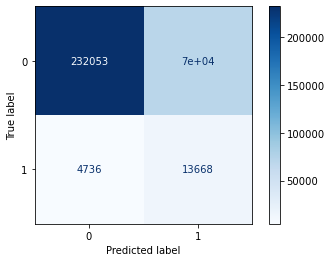

f1 : 0.2671
f3 : 0.5477
f5 : 0.6532
recall : 0.7427
negative predictive value : 0.9800
precision : 0.1629
roc_auc : 0.8353
training time : 42.142s
prediction time : 0.417s


In [47]:
m = Modelisation(X, y, pipeline.set_params(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 3.2. GridSearchCV avec SMOTE

### 3.3. Comparaison

In [48]:
dr1 = restauration_CV('XGBoost_CV_Randomized10000_54000_0.02', verbose=False)
dr2 = restauration_CV('RandomOver_XGBoost_CV_Randomized20000_324000_0.02', verbose=False)

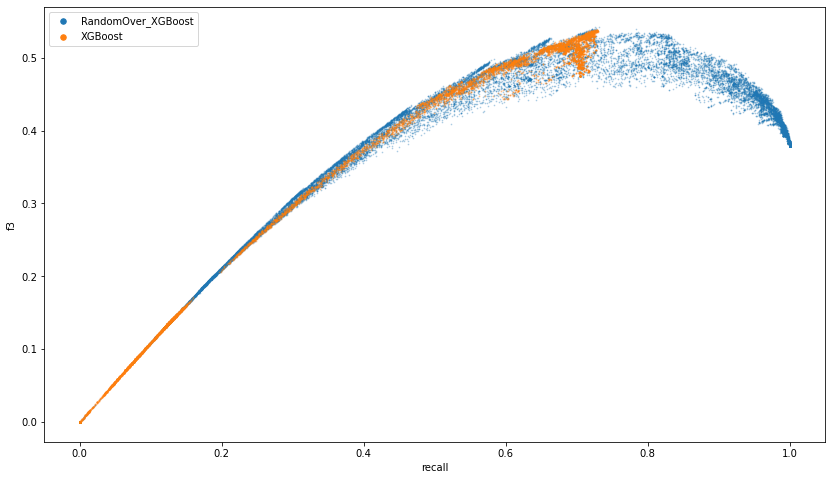

In [49]:
graph_2scores_CV_comp([dr2, dr1], 'recall', 'f3', s=[0.5, 1], alpha=0.3)

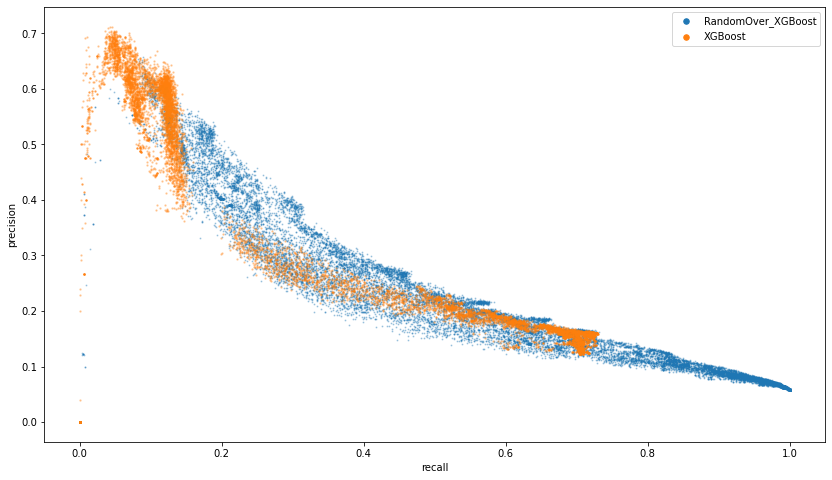

In [50]:
graph_2scores_CV_comp([dr2, dr1], 'recall', 'precision', s=[1, 2], alpha=0.3)

## 4. XGBoost avec RFECV
### 4.1. Sans oversampling

In [51]:
with open("backups/RFECV_XGBoost.json", 'r') as f:
    export = json.load(f)
    columns_quant_RFECV = export['columns_quant']
    columns_cat_RFECV = export['columns_cat']

In [52]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', n_jobs=1)

cv_params = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [2, 4, 6, 8, 10],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "scale_pos_weight": [1, 16.5]   # A typical value to consider: sum(negative instances) / sum(positive instances)
}

print(len(ParameterGrid(cv_params)))

54000


In [53]:
# SearchCV(model, cv_params, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV, data_frac=0.02, random=True, n_iter=10000, random_state=1234, n_jobs=28, name='RFECV')

In [54]:
dico, results = restauration_CV('XGBoost_RFECV_CV_Randomized10000_54000_0.02')

model : XGBClassifier()
model_name : XGBoost_RFECV
type : RandomizedSearchCV
len_grid : 54000
n_iter : 10000
columns_quant : ['campaignctrlast24h', 'contextid', 'nbdayssincelastclick', 'nbdisplay_1hour', 'zonecostineuro']
columns_cat : ['device_type_Android', 'device_type_Desktop', 'device_type_iPad', 'is_interstitial_True']
drop : if_binary
data_frac : 0.02
n_jobs : 28
temps : 2h, 27min, 9.478s
params : {'n_estimators': [50, 100, 150, 200, 300], 'max_depth': [2, 4, 6, 8, 10], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'gamma': [0.5, 1, 1.5, 2, 5], 'min_child_weight': [1, 3, 5, 10], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'scale_pos_weight': [1, 16.5]}
scoring : {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'f3': make_scorer(fbeta_score, beta=3), 'f5': make_scorer(fbeta_score, beta=5)}


In [55]:
best_params = best_score_CV(dico, results, 'f3', display_table=False)

Meilleure combinaison de paramètres pour f3 :


{'subsample': 1.0,
 'scale_pos_weight': 16.5,
 'n_estimators': 150,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 0.6}

In [56]:
best_params['booster'] = 'gbtree'
best_params['objective'] = 'binary:logistic'
best_params['n_jobs'] = -1
best_params['n_estimators'] = 100
PARAMS[dico['model_name']] = best_params

In [57]:
datasets_df_RFECV = datasets(df, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV)
X_RFECV = datasets_df_RFECV['X']

Columns_quant : ['campaignctrlast24h', 'contextid', 'nbdayssincelastclick', 'nbdisplay_1hour', 'zonecostineuro']
Columns_cat : ['device_type_Android', 'device_type_Desktop', 'device_type_iPad', 'is_interstitial_True']
drop : if_binary

Nombre de variables pour X_quant : 5



Index(['campaignctrlast24h', 'contextid', 'nbdayssincelastclick',
       'nbdisplay_1hour', 'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 4



Index(['device_type_Android', 'device_type_Desktop', 'device_type_iPad',
       'is_interstitial_True'],
      dtype='object')


Nombre de variables pour X : 9


Export PDF : output/model_xgboost/24.pdf



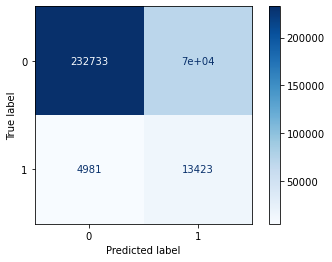

f1 : 0.2648
f3 : 0.5399
f5 : 0.6426
recall : 0.7294
negative predictive value : 0.9790
precision : 0.1617
roc_auc : 0.8289
training time : 11.12s
prediction time : 0.099s


In [58]:
m = Modelisation(X_RFECV, y, XGBClassifier(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 4.2. Avec oversampling

In [59]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', XGBClassifier(booster='gbtree', objective='binary:logistic', n_jobs=1))
                         ])

cv_params = {
    "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    "model__n_estimators": [50, 100, 150, 200, 300],
    "model__max_depth": [2, 4, 6, 8, 10],
    "model__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    "model__gamma": [0.5, 1, 1.5, 2, 5],
    "model__min_child_weight": [1, 3, 5, 10],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__scale_pos_weight": [1, 16.5]   # A typical value to consider: sum(negative instances) / sum(positive instances)
}

print(len(ParameterGrid(cv_params)))

324000


In [60]:
# SearchCV(pipeline, cv_params, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV, data_frac=0.02, random=True, n_iter=20000, random_state=1234, n_jobs=28, name='RFECV')

In [61]:
dico, results = restauration_CV('RandomOver_XGBoost_RFECV_CV_Randomized20000_324000_0.02')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', XGBClassifier())])
model_name : RandomOver_XGBoost_RFECV
type : RandomizedSearchCV
len_grid : 324000
n_iter : 20000
columns_quant : ['campaignctrlast24h', 'contextid', 'nbdayssincelastclick', 'nbdisplay_1hour', 'zonecostineuro']
columns_cat : ['device_type_Android', 'device_type_Desktop', 'device_type_iPad', 'is_interstitial_True']
drop : if_binary
data_frac : 0.02
n_jobs : 28
temps : 7h, 5min, 28.895s
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__n_estimators': [50, 100, 150, 200, 300], 'model__max_depth': [2, 4, 6, 8, 10], 'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'model__gamma': [0.5, 1, 1.5, 2, 5], 'model__min_child_weight': [1, 3, 5, 10], 'model__subsample': [0.6, 0.8, 1.0], 'model__colsample_bytree': [0.6, 0.8, 1.0], 'model__scale_pos_weight': [1, 16.5]}
scoring : {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'f3': make_sc

In [62]:
best_params = best_score_CV(dico, results, 'f3', display_table=False)

Meilleure combinaison de paramètres pour f3 :


{'over__sampling_strategy': 1,
 'model__subsample': 0.8,
 'model__scale_pos_weight': 1,
 'model__n_estimators': 100,
 'model__min_child_weight': 5,
 'model__max_depth': 2,
 'model__learning_rate': 0.3,
 'model__gamma': 2,
 'model__colsample_bytree': 0.6}

In [63]:
best_params['model__booster'] = 'gbtree'
best_params['model__objective'] = 'binary:logistic'
best_params['model__n_jobs'] = -1
best_params['model__n_estimators'] = 100
PARAMS[dico['model_name']] = best_params
with open("backups/PARAMS_XGBoost.json", 'w') as f:
    json.dump(PARAMS, f, indent=2)

Export PDF : output/model_xgboost/25.pdf



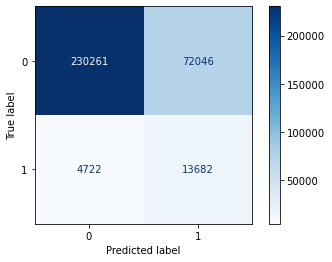

f1 : 0.2628
f3 : 0.5443
f5 : 0.6517
recall : 0.7434
negative predictive value : 0.9799
precision : 0.1596
roc_auc : 0.8311
training time : 26.09s
prediction time : 0.115s


In [64]:
m = Modelisation(X_RFECV, y, pipeline.set_params(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 4.3. Comparaison

In [65]:
dr1 = restauration_CV('XGBoost_CV_Randomized10000_54000_0.02', verbose=False)
dr2 = restauration_CV('XGBoost_RFECV_CV_Randomized10000_54000_0.02', verbose=False)
dr3 = restauration_CV('RandomOver_XGBoost_CV_Randomized20000_324000_0.02', verbose=False)
dr4 = restauration_CV('RandomOver_XGBoost_RFECV_CV_Randomized20000_324000_0.02', verbose=False)

Export PDF : output/model_xgboost/26.pdf



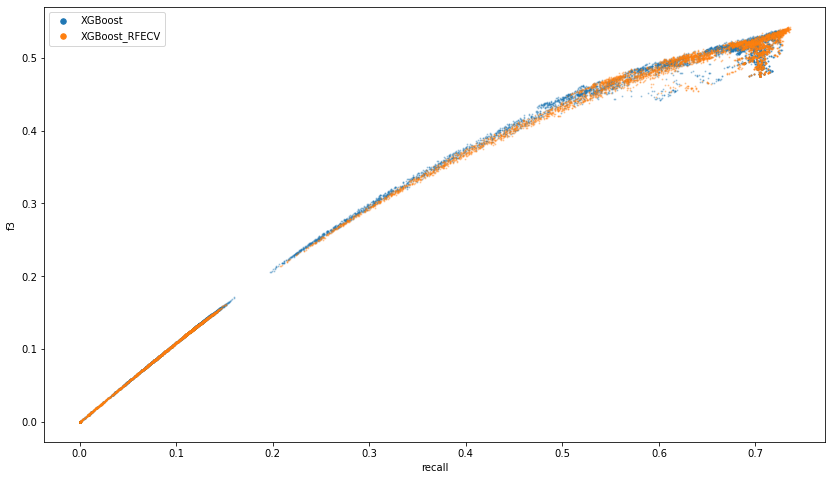

In [66]:
graph_2scores_CV_comp([dr1, dr2], 'recall', 'f3', s=[1, 1], alpha=0.3, pdf=pdf)

Export PDF : output/model_xgboost/27.pdf



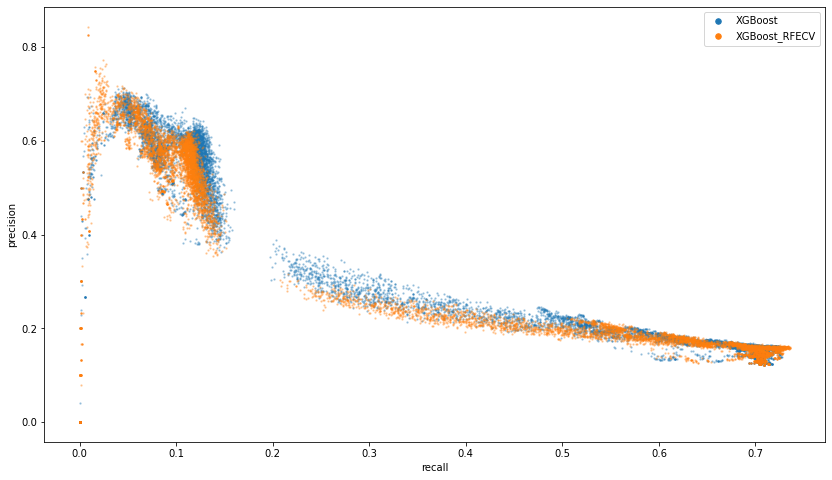

In [67]:
graph_2scores_CV_comp([dr1, dr2], 'recall', 'precision', s=[2, 2], alpha=0.3, pdf=pdf)

Export PDF : output/model_xgboost/28.pdf



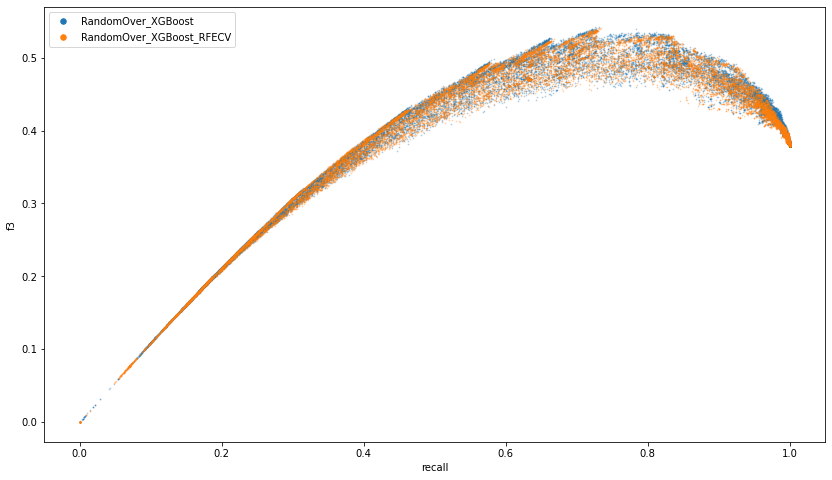

In [68]:
graph_2scores_CV_comp([dr3, dr4], 'recall', 'f3', s=[0.5, 0.5], alpha=0.3, pdf=pdf)

Export PDF : output/model_xgboost/29.pdf



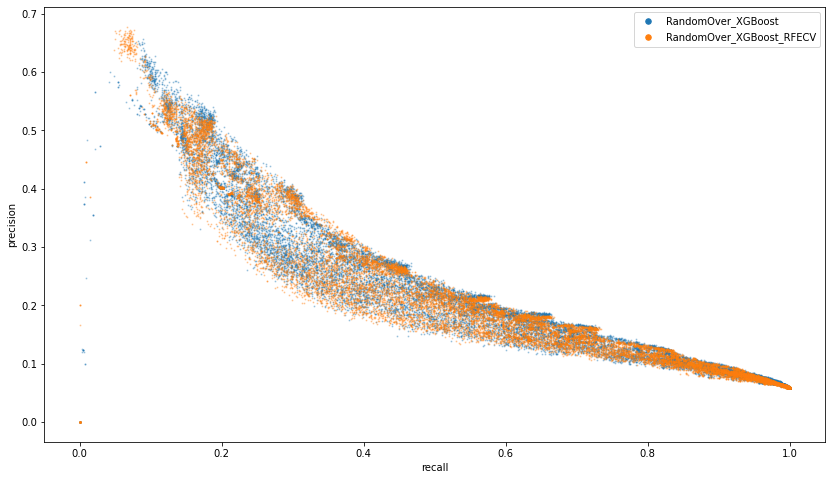

In [69]:
graph_2scores_CV_comp([dr3, dr4], 'recall', 'precision', s=[1, 1], alpha=0.3, pdf=pdf)

## 5. Bilan

In [70]:
scores_df = pd.DataFrame(SCORES).set_index('model_name')
a = scores_df.columns.tolist()
a.remove('training_time')
a.remove('prediction_time')
scores_df.sort_values(by='f3', ascending=False).to_csv('backups/SCORES_XGBoost.csv')
scores_df.sort_values(by='f3', ascending=False).style.background_gradient(cmap='Blues', subset=a).background_gradient(cmap='Blues_r', subset=['training_time', 'prediction_time'])

,f1,f3,f5,recall,negative predictive value,precision,roc_auc,training_time,prediction_time
model_name,,,,,,,,,
XGBoost,0.267886,0.547788,0.652708,0.741469,0.979944,0.163474,0.835527,18.250862,0.436802
RandomOver_XGBoost,0.267146,0.547688,0.653224,0.742665,0.979999,0.162866,0.835328,42.141877,0.417115
RandomOver_XGBoost_RFECV,0.262782,0.544310,0.651729,0.743425,0.979905,0.159598,0.831101,26.089831,0.115172
XGBoost_RFECV,0.264751,0.539872,0.642607,0.729352,0.979046,0.161729,0.828913,11.119976,0.099294


In [71]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:05:56
